In [1]:
import os
from pyspark.sql.functions import regexp_extract
from pyspark.sql.types import *
import pandas as pd
from pyspark.sql.functions import split
from pyspark import SparkContext
from pyspark.sql import SQLContext
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import geoplot
import boto3
import re
from io import StringIO

In [2]:
sc = SparkContext("local", "First App")
sqlContext = SQLContext(sc)

In [3]:
#getting data from S3
s3 = boto3.resource('s3')
bucket = s3.Bucket('geo-clustering')
obj = bucket.Object(key='sample_geo.txt')
response = obj.get()
lines = response[u'Body'].read().split(b'\n')
raw_data=[]
for line in lines[1:]:
     raw_data.append(str(line, 'utf-8'))
x=raw_data.pop()
print(len(lines))

9972


In [4]:
#creating a pyspark data frame after extracting columns
raw_rdd = sc.parallelize(raw_data)
split_rdd=raw_rdd.map(lambda line: re.split('\\t',line))
sample_geo_raw_split=split_rdd.toDF()

In [5]:
#Removing longitudes and latitides with 0 magnitude
sample_geo_no_zero_lat = sample_geo_raw_split.filter(sample_geo_raw_split._1 != 0)

In [6]:
#renaming columns
sample_geo=sample_geo_no_zero_lat.select("_1","_2").withColumnRenamed("_1","latitude").withColumnRenamed("_2","longitude")

### VISUALIZATION USING GEOPANDAS

In [7]:
#Converting to pandas dataframe
sample_geo_pd=sample_geo.toPandas()
#Converting type of longitude and latitude to float from string to plot
sample_geo_pd=sample_geo_pd.astype({'latitude': 'float64'})
sample_geo_pd=sample_geo_pd.astype({'longitude': 'float64'})

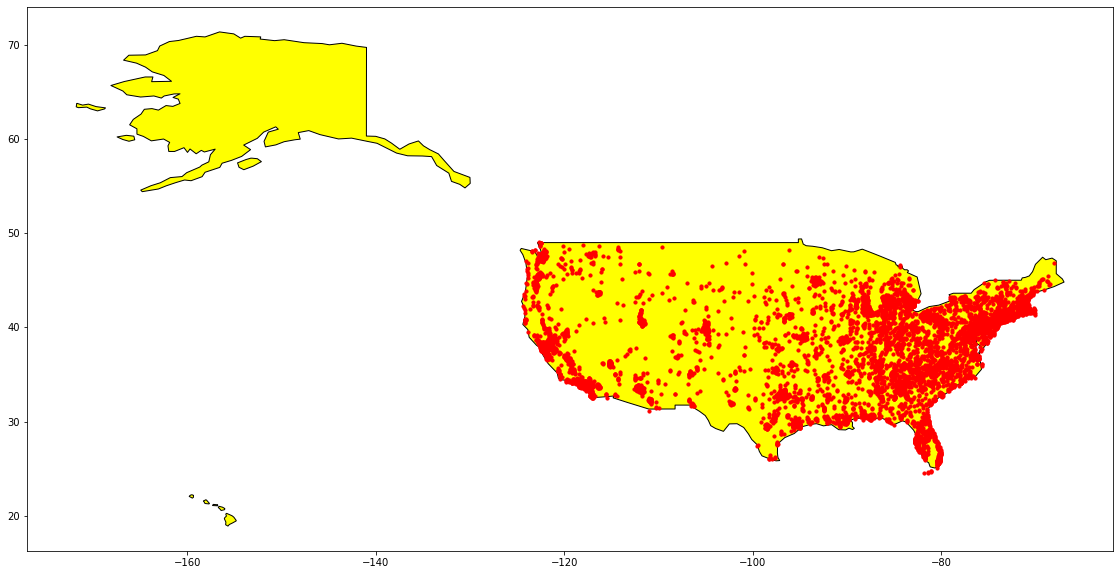

In [8]:
#plotting the grapgh
geometry = [Point(xy) for xy in zip(sample_geo_pd['longitude'], sample_geo_pd['latitude'])]
gdf = GeoDataFrame(sample_geo_pd, geometry=geometry)   
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax=world[world.name == 'United States of America'].plot(color='yellow', edgecolor='black',figsize=(20, 10))
gdf.plot(ax=ax, marker='o', color='red', markersize=10);

In [11]:
csv_buffer = StringIO()
sample_geo_pd.to_csv(csv_buffer, sep="|", index=False)
s3.Object("geo-clustering", "sample_geo_processed.csv").put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '106C50E7EFB506A2',
  'HostId': 'irLNrj6FyUwpYkM5wJoJp1Wrv8Yosve363eRkUNNjG1/evGqM0oayFdAT6yOiZ3VrP3maGg4d+8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'irLNrj6FyUwpYkM5wJoJp1Wrv8Yosve363eRkUNNjG1/evGqM0oayFdAT6yOiZ3VrP3maGg4d+8=',
   'x-amz-request-id': '106C50E7EFB506A2',
   'date': 'Fri, 27 Nov 2020 01:49:34 GMT',
   'etag': '"6c5cfe4a86f3cf99900b70c3506a0613"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"6c5cfe4a86f3cf99900b70c3506a0613"'}